In [1]:
import os
import chess.pgn
from datetime import datetime
from ipywidgets import IntProgress
from IPython.display import display

print('Preloading games...')
limit = 10_000
games = []
f = IntProgress(min=0, max=limit) # instantiate the bar
display(f) # display the bar

for path in os.listdir("datasets"):
    with open(f'datasets/{path}') as file:
        while len(games) < limit:
            game = chess.pgn.read_game(file)
            if game is None:
                break

            date = game.headers.get('UTCDate')  # 2012.12.31
            time = game.headers.get('UTCTime')  # 23:04:12

            ts_game = {
                'id': game.headers.get('Site').split('/')[-1],  # [Site "https://lichess.org/j1dkb5dw"]
                'link': game.headers.get('Site'),
                'timestamp_utc': int(datetime.strptime(f'{date} {time}', '%Y.%m.%d %H:%M:%S').timestamp()),
                'event': game.headers.get('Event'),
                'white': game.headers.get('White'),
                'black': game.headers.get('Black'),
                'opening': game.headers.get('Opening'),
                'termination': game.headers.get('Termination'),
                'mainline_moves': str(game.mainline_moves()),
            }

            games.append(ts_game)
            f.value += 1
f.layout.display = 'none'
print('Loaded {} games'.format(len(games)))


def print_game(game):
    print(f"{game['white']} vs {game['black']} ({game['event']})")
    print(game['link'])
    print(game['mainline_moves'])
    print()

def make_markdown_table(array):
    nl = "\n"
    markdown = nl
    markdown += f"| {' | '.join(array[0])} |"
    markdown += nl
    markdown += f"| {' | '.join(['---']*len(array[0]))} |"
    markdown += nl
    for entry in array[1:]:
        markdown += f"| {' | '.join(map(lambda c: str(c), entry))} |{nl}"
    return markdown

# noinspection PyShadowingBuiltins
def human_size(bytes, units=None):
    minus = bytes < 0
    if minus:
        bytes = -bytes
    if units is None:
        units = [' bytes', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB']
    formatted = str(bytes) + units[0] if bytes < 1024 or len(units) == 1 else human_size(bytes >> 10, units[1:])
    if minus:
        formatted = '-' + formatted
    return formatted

Preloading games...


IntProgress(value=0, max=10000)

Loaded 10000 games


# Typesense

In [2]:
import requests
import typesense
typesense_url = "http://localhost:8108"
typesense_api_key = "xyz"
typesense_api_key_header = "X-TYPESENSE-API-KEY"

typesense_client = typesense.Client({
    'nodes': [{
        'host': 'localhost',
        'port': '8108',
        'protocol': 'http'
    }],
    'api_key': 'xyz',
    'connection_timeout_seconds': 2
})

collection_name = 'chess'

measurements = []

def measure_metrics():
    measurement = requests.get(f"{typesense_url}/metrics.json",
                               headers={typesense_api_key_header: typesense_api_key}).json()

    measurement['system_cpu_active_percentage'] = float(measurement['system_cpu_active_percentage'])
    measurement['system_disk_used_bytes'] = int(measurement['system_disk_used_bytes'])
    measurement['system_memory_used_bytes'] = int(measurement['system_memory_used_bytes'])
    measurement['system_network_received_bytes'] = int(measurement['system_network_received_bytes'])
    measurement['system_network_sent_bytes'] = int(measurement['system_network_sent_bytes'])
    measurement['typesense_memory_active_bytes'] = int(measurement['typesense_memory_active_bytes'])
    measurement['typesense_memory_allocated_bytes'] = int(measurement['typesense_memory_allocated_bytes'])
    measurement['typesense_memory_mapped_bytes'] = int(measurement['typesense_memory_mapped_bytes'])
    measurement['typesense_memory_metadata_bytes'] = int(measurement['typesense_memory_metadata_bytes'])
    measurement['typesense_memory_fragmentation_ratio'] = float(measurement['typesense_memory_fragmentation_ratio'])
    measurement['typesense_memory_resident_bytes'] = int(measurement['typesense_memory_resident_bytes'])
    measurement['typesense_memory_retained_bytes'] = int(measurement['typesense_memory_retained_bytes'])
    measurements.append(measurement)
    return measurement


def subtract_measurements(m1, m2):
    m = {'system_cpu_active_percentage': m1['system_cpu_active_percentage'] - m2['system_cpu_active_percentage'],
         'system_disk_used_bytes': m1['system_disk_used_bytes'] - m2['system_disk_used_bytes'],
         'system_memory_used_bytes': m1['system_memory_used_bytes'] - m2['system_memory_used_bytes'],
         'system_network_received_bytes': m1['system_network_received_bytes'] - m2['system_network_received_bytes'],
         'system_network_sent_bytes': m1['system_network_sent_bytes'] - m2['system_network_sent_bytes'],
         'typesense_memory_active_bytes': m1['typesense_memory_active_bytes'] - m2['typesense_memory_active_bytes'],
         'typesense_memory_allocated_bytes': m1['typesense_memory_allocated_bytes'] - m2[
             'typesense_memory_allocated_bytes'],
         'typesense_memory_mapped_bytes': m1['typesense_memory_mapped_bytes'] - m2['typesense_memory_mapped_bytes'],
         'typesense_memory_metadata_bytes': m1['typesense_memory_metadata_bytes'] - m2[
             'typesense_memory_metadata_bytes'],
         'typesense_memory_fragmentation_ratio': m1['typesense_memory_fragmentation_ratio'] - m2[
             'typesense_memory_fragmentation_ratio'],
         'typesense_memory_resident_bytes': m1['typesense_memory_resident_bytes'] - m2[
             'typesense_memory_resident_bytes'],
         'typesense_memory_retained_bytes': m1['typesense_memory_retained_bytes'] - m2[
             'typesense_memory_retained_bytes']}

    return m


def display_metrics_text(measurement):
    print(f"CPU:                                  {measurement['system_cpu_active_percentage']}%")
    print(f"system_disk_used_bytes:               {human_size((measurement['system_disk_used_bytes']))}")
    print(f"system_memory_used_bytes:             {human_size((measurement['system_memory_used_bytes']))}")
    print(f"system_network_received_bytes:        {human_size((measurement['system_network_received_bytes']))}")
    print(f"system_network_sent_bytes:            {human_size((measurement['system_network_sent_bytes']))}")
    print(f"typesense_memory_active_bytes:        {human_size((measurement['typesense_memory_active_bytes']))}")
    print(f"typesense_memory_allocated_bytes:     {human_size((measurement['typesense_memory_allocated_bytes']))}")
    print(f"typesense_memory_mapped_bytes:        {human_size((measurement['typesense_memory_mapped_bytes']))}")
    print(f"typesense_memory_metadata_bytes:      {human_size((measurement['typesense_memory_metadata_bytes']))}")
    print(f"typesense_memory_fragmentation_ratio: {measurement['typesense_memory_fragmentation_ratio']}")
    print(f"typesense_memory_resident_bytes:      {human_size((measurement['typesense_memory_resident_bytes']))}")
    print(f"typesense_memory_retained_bytes:      {human_size((measurement['typesense_memory_retained_bytes']))}")

1. Średni czas przetwarzania zadania zawierającego 10000 dokumentów (porównanie bedzie się zaczynać na pustym indeksie)

In [3]:
print("Re/Creating collection...")
schema = {
    'name': collection_name,
    'fields': [
        {'name': 'link', 'type': 'string'},  # [Site "https://lichess.org/j1dkb5dw"]
        {'name': 'timestamp_utc', 'type': 'int32'},  # [UTCDate "2012.12.31"] [UTCTime "23:04:12"]
        {'name': 'event', 'type': 'string'},  # [Event "Rated Classical game"]
        {'name': 'white', 'type': 'string'},  # [White "BFG9k"]
        {'name': 'black', 'type': 'string'},  # [Black "mamalak"]
        {'name': 'opening', 'type': 'string'},  # [Opening "French Defense: Normal Variation"]
        {'name': 'termination', 'type': 'string'},  # [Termination "Normal"]
        {'name': 'mainline_moves', 'type': 'string'},  # 1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2...
    ],
    'default_sorting_field': 'timestamp_utc'
}

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

before = measure_metrics()

Re/Creating collection...


In [4]:
%%timeit
global collection

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

typesense_client.collections.create(schema)

collection = typesense_client.collections[collection_name]

collection.documents.import_(games, {
    'action': 'upsert',
})

1.02 s ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
after = measure_metrics()

2. Czas odpowiedzi na pojedyncze zapytania

In [6]:
query = "1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6"
print("Searching for '{}'...".format(query))
params = {
    'q': query,
    'query_by': 'mainline_moves',
    'per_page': 10,
    'page': 1,
}

Searching for '1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6'...


In [7]:
%%timeit
global collection
global results
results = collection.documents.search(params)

15 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


3. Porównanie wyników wyszukiwania dla jednakowych zapytań

In [8]:
tp = 0
fp = 0
relevant = 0
next_page = True
page = 1
while next_page:
    r = sum(1 if query in x['document']['mainline_moves'] else 0 for x in collection.documents.search({
        'q': query,
        'query_by': 'mainline_moves',
        'per_page': 250,
        'page': page,
    })['hits'])
    page += 1
    relevant += r
    if r == 0:
        next_page = False

for result in results['hits']:
    if query in result['document']['mainline_moves']:
        tp += 1
    else:
        fp += 1
    if tp + fp <= 10:
        print_game(result['document'])

print()
print("Total relevant: {}".format(relevant))
print("False positives: {:.02f}".format(fp))
print("True positives: {:.02f}".format(tp))
print("Precision: {:.02f}".format(tp / (tp + fp)))
print("Recall: {:.02f}".format(tp / relevant))
print("F1: {:.02f}".format(2 * (tp / (tp + fp)) * (tp / relevant) / ((tp / (tp + fp)) + (tp / relevant))))

Fisher62 vs bert (Rated Classical game)
https://lichess.org/cndw3ifd
1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. O-O Nxe4 6. Re1 d5 7. d3 Nd6 8. Nxe5 Be7 9. Bxc6+ Kf8 10. Bxd5 Be6 11. Bxe6 fxe6 12. Qf3+ Bf6 13. Bg5 h6 14. Ng6+ Kf7 15. Nxh8+ Qxh8 16. Bxf6 gxf6 17. Nc3 h5 18. Ne4 Nf5 19. Ng3 Ng7 20. Qxb7 Rc8 21. Qxa6 h4 22. Ne4 h3 23. g3 Re8 24. Qc6 Re7 25. a4 Qh5 26. Nd2 Qf5 27. Qf3 Qa5 28. c3 c5 29. Reb1 e5 30. b4 cxb4 31. cxb4 Qc7 32. Nc4 Ne6 33. Qh5+ Kg8 34. Qxh3 Nd4 35. Qg4+ Rg7 36. Qd1 Qc6 37. Nd2 Rh7 38. b5 Qd7 39. Qf1 Qg4 40. Qg2 Ne2+ 41. Kf1 Nd4 42. Re1 Qe6 43. Nf3 Nc2 44. Rac1 Nxe1 45. Nxe1 Qa2 46. Rc8+ Kg7 47. Rc7+ Kg6 48. Rxh7 Kxh7 49. b6 Kg7 50. b7 Qb3 51. a5

Fisher62 vs Rodney (Rated Classical game)
https://lichess.org/3vnli7c6
1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 b5 5. Bb3 d6 6. h3 Nf6 7. O-O Nxe4 8. Re1 Nf6 9. d4 Be7 10. dxe5 dxe5 11. Qxd8+ Bxd8 12. Nxe5 Nxe5 13. Rxe5+ Be7 14. Bd5 Rb8 15. Bc6+ Bd7 16. Bxd7+ Nxd7 17. Re3 Rb6 18. Bd2 Re6 19. Rxe6 fxe6 20. Nc3 O-O 21. Re1 B

4. Zużycie procesora i RAMu w momencie przetwarzania zadania zawierającego 10000 dokumentów

In [9]:
print("BEFORE")
display_metrics_text(before)
print()

print("AFTER")
display_metrics_text(after)
print()

print("DIFF")
display_metrics_text(subtract_measurements(after, before))

BEFORE
CPU:                                  1.65%
system_disk_used_bytes:               27GB
system_memory_used_bytes:             15GB
system_network_received_bytes:        2KB
system_network_sent_bytes:            1KB
typesense_memory_active_bytes:        95MB
typesense_memory_allocated_bytes:     56MB
typesense_memory_mapped_bytes:        228MB
typesense_memory_metadata_bytes:      18MB
typesense_memory_fragmentation_ratio: 0.41
typesense_memory_resident_bytes:      95MB
typesense_memory_retained_bytes:      555MB

AFTER
CPU:                                  0.0%
system_disk_used_bytes:               27GB
system_memory_used_bytes:             15GB
system_network_received_bytes:        50MB
system_network_sent_bytes:            104KB
typesense_memory_active_bytes:        115MB
typesense_memory_allocated_bytes:     71MB
typesense_memory_mapped_bytes:        505MB
typesense_memory_metadata_bytes:      19MB
typesense_memory_fragmentation_ratio: 0.38
typesense_memory_resident_bytes:    

5. Średni czas odpowiedzi pzry wielu jednoczesnych wyszukiwaniach - analiza przeprowadzona będzie na jednej maszynie, przy użyciu jednego skryptu wysyłajacego zapytania HTTP aby zminimalizować wpływ innych czynników niz silnik

In [10]:
import requests
from timeit import default_timer as timer
from concurrent.futures import ThreadPoolExecutor

def query(n):
    start = timer()
    collection.documents.search(params)
    end = timer()
    return end - start

with ThreadPoolExecutor(max_workers=10000) as pool:
    r = list(pool.map(query,range(10000)))
    print(f"Average time: {sum(r)/len(r):.2f} seconds")

Average time: 0.41 seconds


6. Wzrost wielkości indeksu w zależnosci od ilości zaindeksowanch dokumentów

Indexing batch 1...
Indexing batch 2...
Indexing batch 3...
Indexing batch 4...
Indexing batch 5...
Indexing batch 6...
Indexing batch 7...
Indexing batch 8...
Indexing batch 9...
Indexing batch 10...


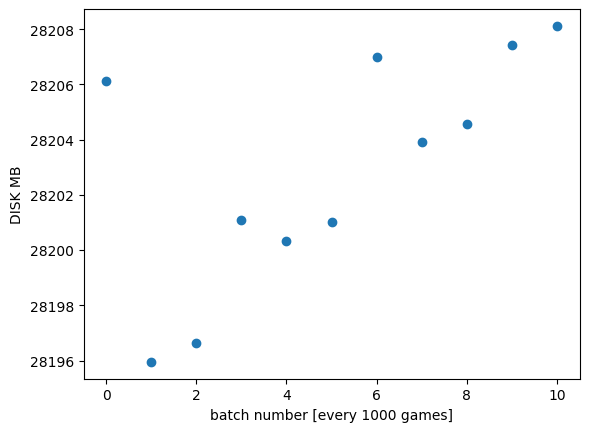

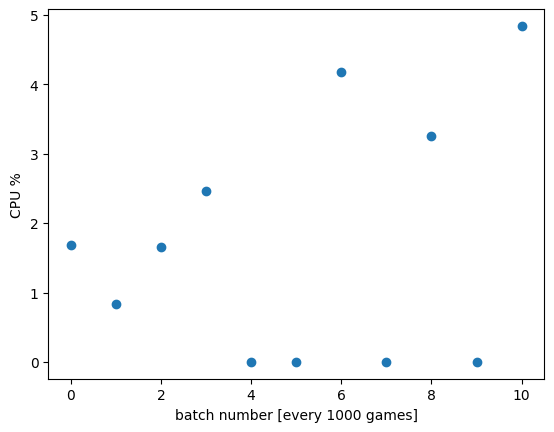

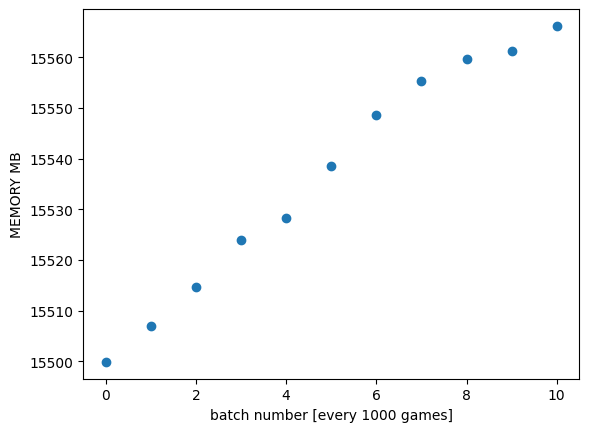

In [11]:
import matplotlib.pyplot as plt

batch_size = 1000

def plot(data, name):
    x = [i for i, _ in enumerate(data)]
    y = data

    plt.xlabel(f'batch number [every {batch_size} games]')
    plt.ylabel(name)
    plt.scatter(x, y)
    plt.show()


def plot_metric(metric, name, transform=lambda x: x):
    plot([transform(measurement[metric]) for measurement in measurements], name)

measurements.clear()

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

typesense_client.collections.create(schema)

collection = typesense_client.collections[collection_name]

measure_metrics()
for i in range(0, len(games), batch_size):
    print(f"Indexing batch {i // batch_size + 1}...")
    collection.documents.import_(games[i:i+batch_size], {
        'action': 'upsert',
    })
    measure_metrics()

plot_metric("system_disk_used_bytes", "DISK MB", lambda x: float(x) / 1024.0 / 1024.0)
plot_metric("system_cpu_active_percentage", "CPU %", lambda x: float(x))
plot_metric("system_memory_used_bytes", "MEMORY MB", lambda x: float(x) / 1024.0 / 1024.0)

7. Porównanie wsparcia da popularnych jezyków programowania oraz próba określenia łatwości korzystania z dokumentacji i jej kompletności

# Elasticsearch

In [12]:
from IPython.core.display import Markdown
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import requests

elasticsearch_url = "http://localhost:9200"
elasticsearch_client = Elasticsearch(elasticsearch_url)
collection_name = 'chess'

def get_es_stats(description):
    node_name = list(elasticsearch_client.nodes.stats()["nodes"].keys())[0]
    stats = elasticsearch_client.nodes.stats(node_id=node_name)["nodes"][node_name]
    measures = {}
    measures["Description"] = description
    measures["CPU"] = stats['os']['cpu']['percent']
    measures["Disk used"] = stats["fs"]["total"]["total_in_bytes"] - stats["fs"]["total"]["free_in_bytes"]
    measures["Memory usage (total)"] = stats["os"]["mem"]["used_in_bytes"]
    measures["Memory usage (jvm)"] = stats["jvm"]["mem"]["heap_used_in_bytes"] + stats["jvm"]["mem"]["non_heap_used_in_bytes"]
    measures["Documents"] = stats["indices"]["docs"]["count"]
    measures["Store size"] = stats["indices"]["store"]["size_in_bytes"]
    if elasticsearch_client.indices.get(index=collection_name, ignore_unavailable=True) == {}:
        measures[f"Index \"{collection_name}\" store size"] = 0
    else:
        measures[f"Index \"{collection_name}\" store size"] = elasticsearch_client.indices.disk_usage(index=collection_name, run_expensive_tasks=True)["chess"]["store_size_in_bytes"]
    return measures

def get_values_differences(d1, d2):
    results = {}
    if d1.keys() == d2.keys():
        for key in d1:
            if isinstance(d1[key], (int, float, complex)) and isinstance(d1[key], (int, float, complex)):
                results[key] = d1[key] - d2[key]
            else:
                results[key] = d1[key]
    return results

def print_stats_list(stats_dictionaries):
    units = [' bytes', 'KB', 'MB']
    rows = [stats_dictionaries[0].keys()]
    for dictionary in stats_dictionaries:
        values = list(dictionary.values())
        rows.append([values[0], f"{values[1]}%", f"{ human_size(values[2], units)}", f"{ human_size(values[3], units)}", f"{ human_size(values[4], units)}", values[5], f"{ human_size(values[6], units)}", f"{human_size(values[7], units)}"])
    display(Markdown(make_markdown_table(rows)))

1. Średni czas przetwarzania zadania zawierającego 10000 dokumentów (porównanie bedzie się zaczynać na pustym indeksie)


In [13]:
print("Re/Creating collection...")
schema = {
    "mappings": {
        "properties": {
            "link": {"type": "text"},  # [Site "https://lichess.org/j1dkb5dw"]
            "timestamp_utc": {"type": "integer"},  # [UTCDate "2012.12.31"] [UTCTime "23:04:12"]
            "event": {"type": "text"},  # [Event "Rated Classical game"]
            "white": {"type": "text"},  # [White "BFG9k"]
            "black": {"type": "text"},  # [Black "mamalak"]
            "opening": {"type": "text"},  # [Opening "French Defense: Normal Variation"]
            "termination": {"type": "text"},  # [Termination "Normal"]
            "mainline_moves": {"type": "text"}  # 1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2...
        }
    }
}
elasticsearch_client.indices.delete(index=collection_name,ignore_unavailable=True)
before = get_es_stats("Before")

Re/Creating collection...


In [14]:
%%timeit
elasticsearch_client.indices.delete(index=collection_name,ignore_unavailable=True)
elasticsearch_client.indices.create(index=collection_name,body=schema)
bulk(client=elasticsearch_client, index=collection_name, actions=games)
elasticsearch_client.indices.flush(index=collection_name)

<magic-timeit>:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.


1.39 s ± 399 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
after = get_es_stats("After")

2. Czas odpowiedzi na pojedyncze zapytania

In [16]:
query = "1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6"
print("Searching for '{}'...".format(query))
params = {
    "match": {
        "mainline_moves": {
            "query": query
        }
    }
}

Searching for '1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6'...


In [17]:
%%timeit
global top10
top10 = elasticsearch_client.search(index=collection_name,query=params, size=10)["hits"]["hits"]

11.7 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


3. Porównanie wyników wyszukiwania dla jednakowych zapytań

In [18]:
tp = 0
fp = 0
relevant = 0
next_page = True
page = 1
all_hits = []
while next_page:
    page_hits = elasticsearch_client.search(index=collection_name,query=params, from_=(page-1)*250, size=250)["hits"]["hits"]
    all_hits += page_hits
    page += 1
    if len(page_hits)<250 or page*250>limit:
        next_page = False
relevant += sum(1 if query in hit["_source"]["mainline_moves"] else 0 for hit in all_hits)

for result in top10:
    if query in result["_source"]['mainline_moves']:
        tp += 1
    else:
        fp += 1
    print_game(result["_source"])
print()
print("Total relevant: {}".format(relevant))
print("False positives: {:.02f}".format(fp))
print("True positives: {:.02f}".format(tp))
print("Precision: {:.02f}".format(tp / (tp + fp)))
print("Recall: {:.02f}".format(tp / relevant))
print("F1: {:.02f}".format(2 * (tp / (tp + fp)) * (tp / relevant) / ((tp / (tp + fp)) + (tp / relevant))))

torkin vs ChessThom (Rated Classical game)
https://lichess.org/rtdeje58
1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. d3 Bc5 6. h3 O-O 7. O-O d5 8. Bxc6 bxc6 9. Nxe5 Qd6 10. Ng4 Nxg4

Fisher62 vs fedalio (Rated Blitz game)
https://lichess.org/xgpsv7pd
1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 d6 5. h3 Bd7 6. O-O Nf6 7. Re1 d5 8. exd5 Nxd5 9. Bxc6 Bxc6 10. Nxe5 Bd6 11. Nxc6+

DUMBLEDORE vs JohnUA (Rated Blitz game)
https://lichess.org/jj35bkh8
1. e4 d5 2. exd5 Qxd5 3. Nc3 Qd8 4. Nf3 Nc6 5. Bb5 a6 6. Ba4 b5 7. Bb3 e5 8. O-O b4 9. Ne4 Bg4 10. Ba4 Qd5 11. Re1 Bxf3 12. Qxf3 Bc5 13. Bb3 Qd7 14. Nxc5 Qe7 15. d4 Nxd4 16. Qxa8+ Qd8 17. Bxf7+ Ke7 18. Rxe5+ Kxf7 19. Qxd8

Water27 vs MistySchism (Rated Blitz game)
https://lichess.org/gpdui94z
1. e4 d5 2. exd5 Nf6 3. Bb5+ Nbd7 4. Nf3 a6 5. Ba4 Nxd5 6. O-O b5 7. Bb3 N7b6 8. Nc3 Bb7 9. Nxd5 Nxd5 10. c4 bxc4 11. Ba4+ c6 12. Ne5 Qd6 13. Nxc4 Qb4 14. b3 g6 15. Ba3

german11 vs bojan123 (Rated Blitz game)
https://lichess.org/9mgqnorh
1. e4 e5 2. Nf3 Nc6 3. Bb5 

4. Zużycie procesora i RAMu w momencie przetwarzania zadania zawierającego 10000 dokumentów

In [19]:
difference = get_values_differences(after, before)
difference["Description"] = "Difference"
print_stats_list([before, after, difference])


| Description | CPU | Disk used | Memory usage (total) | Memory usage (jvm) | Documents | Store size | Index "chess" store size |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Before | 0% | 41380MB | 16972MB | 560MB | 42 | 40MB | 0 bytes |
| After | 19% | 41386MB | 16998MB | 815MB | 10042 | 45MB | 5MB |
| Difference | 19% | 5MB | 25MB | 254MB | 10000 | 5MB | 5MB |


5. Średni czas odpowiedzi pzry wielu jednoczesnych wyszukiwaniach - analiza przeprowadzona będzie na jednej maszynie, przy użyciu jednego skryptu wysyłajacego zapytania HTTP aby zminimalizować wpływ innych czynników niz silnik

In [20]:
from timeit import default_timer as timer
from concurrent.futures import ThreadPoolExecutor

def query(n):
    start = timer()
    elasticsearch_client.search(index=collection_name,query=params, sort={"timestamp_utc": {"order": "desc"}}, size=10)
    end = timer()
    return end - start

with ThreadPoolExecutor(max_workers=10000) as pool:
    r = list(pool.map(query,range(10000)))
    print(f"Average time: {sum(r)/len(r):.2f} seconds")

Average time: 3.86 seconds


6. Wzrost wielkości indeksu w zależnosci od ilości zaindeksowanch dokumentów

C:\Users\kbaci\AppData\Local\Temp\ipykernel_22328\298650061.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  elasticsearch_client.indices.create(index=collection_name,body=schema)


Indexing batch 1...
Indexing batch 2...
Indexing batch 3...
Indexing batch 4...
Indexing batch 5...
Indexing batch 6...
Indexing batch 7...
Indexing batch 8...
Indexing batch 9...
Indexing batch 10...


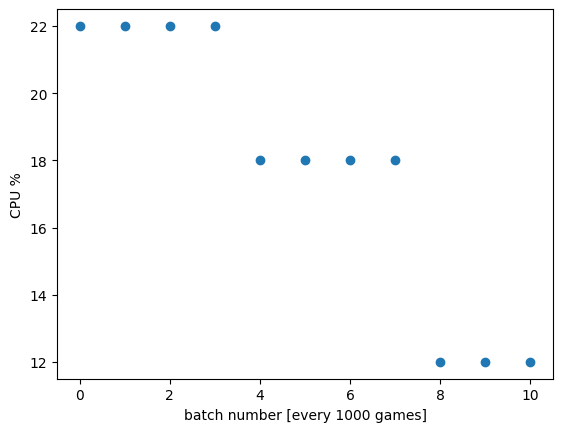

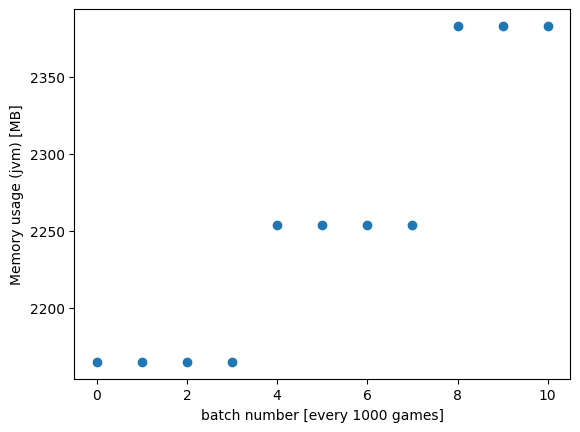

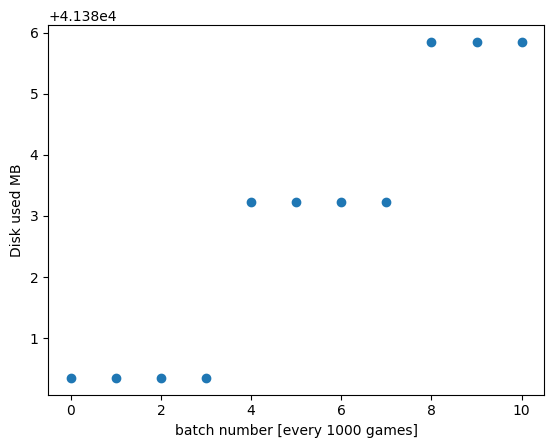

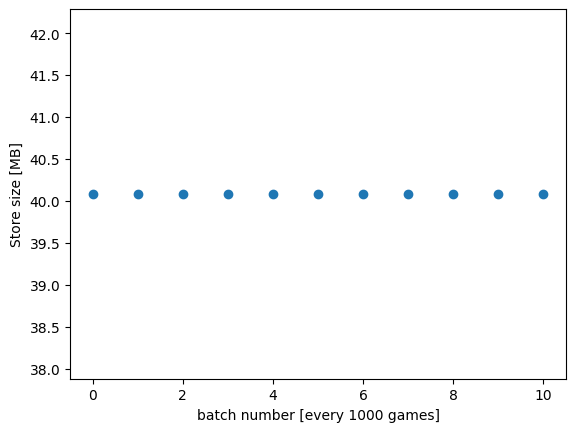

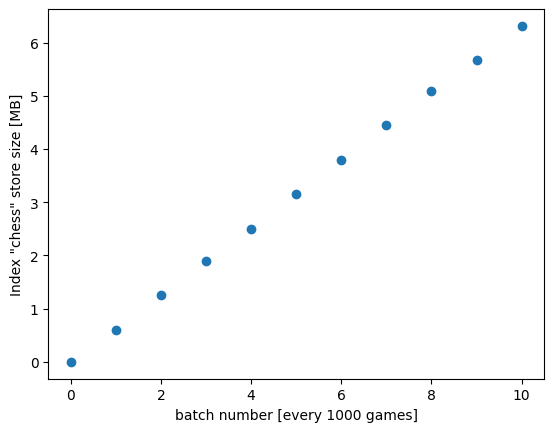

In [21]:
import matplotlib.pyplot as plt

batch_size = 1000

def plot(data, name):
    x = [i for i, _ in enumerate(data)]
    y = data

    plt.xlabel(f'batch number [every {batch_size} games]')
    plt.ylabel(name)
    plt.scatter(x, y)
    plt.show()


def plot_metric(metric, name, transform=lambda x: x):
    plot([transform(measurement[metric]) for measurement in measurements], name)

elasticsearch_client.indices.delete(index=collection_name,ignore_unavailable=True)
elasticsearch_client.indices.create(index=collection_name,body=schema)

measurements = [get_es_stats("before")]

for i in range(0, len(games), batch_size):
    print(f"Indexing batch {i // batch_size + 1}...")
    bulk(client=elasticsearch_client, index=collection_name, actions=games[i:i+batch_size])
    measurements.append(get_es_stats(f"after {i // batch_size + 1} batch"))

plot_metric("CPU", "CPU %", lambda x: float(x))
plot_metric("Memory usage (jvm)", "Memory usage (jvm) [MB]", lambda x: float(x) / 1024.0 / 1024.0)
plot_metric("Disk used", "Disk used MB", lambda x: float(x) / 1024.0 / 1024.0)
plot_metric("Store size", "Store size [MB]", lambda x: x / 1024.0 / 1024.0)
plot_metric(f"Index \"{collection_name}\" store size", f"Index \"{collection_name}\" store size [MB]", lambda x: x / 1024.0 / 1024.0)

7. Porównanie wsparcia da popularnych jezyków programowania oraz próba określenia łatwości korzystania z dokumentacji i jej kompletności

Elasticsearch posiada klienta dla każdego znaczącego języka, oficjalnego (jak w przypadku języków Java, JavaScript, Ruby, Go, .NET, PHP, Perl, Python, Eland, Rust), bądź nieoficjalnego; może być również obsługiwany przez zapytania do restowego API (klienty to tak naprawdę bardziej lub mniej rozbudowane nakładki).

Dokumentacja dla Javy jest kompletna i obfita przykłady, jednak w przypadku pythonowego klienta trzeba posiłkować się dokumentacją API by poznać dopuszczalne argumenty i struktury obiektów.

Implementacja zarówno w Scali jak i Pythonie przebiegała bezproblemowo.

Jedyne uwagi można mieć do Kibany (GUI panelu administracyjnego), która ukrywa część informacji dotyczących obiektów utworzonych przez klienta/API (np. trzeba dodać ręcznie informację o utworzonym w kliencie indeksie by wyświetlić jego statystyki). Istnieją jednak alternatywne rozwiązania (np. rozszerzenie Elasticvue do przeglądarek).

# Solr

In [22]:
# Init solr


import requests
from timeit import default_timer as timer
from concurrent.futures import ThreadPoolExecutor
import chess.pgn
from datetime import datetime


def create_index():
    requests.post("http://localhost:8983/api/collections", json={
        "create": {
            "name": "chess",
            "numShards": 1,
            "replicationFactor": 1
        }
    })

    requests.post("http://localhost:8983/api/collections/chess/schema", json={
        "add-field": [
            {"name": "link", "type": "text_general"},
            {"name": "timestampUtc", "type": "pint"},
            {"name": "event", "type": "text_general"},
            {"name": "white", "type": "text_general"},
            {"name": "black", "type": "text_general"},
            {"name": "whiteElo", "type": "pint"},
            {"name": "blackElo", "type": "pint"},
            {"name": "opening", "type": "text_general"},
            {"name": "mainline_moves", "type": "text_general"}
        ]
    })


def get_10000():
    with open("./datasets/lichess_db_standard_rated_2013-01.pgn") as file:
        docs = []
        while True:
            game = chess.pgn.read_game(file)

            if len(docs) == 10000:
                return docs

            date = game.headers.get('UTCDate')  # 2012.12.31
            time = game.headers.get('UTCTime')  # 23:04:12
            white_elo = game.headers.get('WhiteElo')
            black_elo = game.headers.get('BlackElo')

            game = {
                'id': game.headers.get('Site').split('/')[-1],  # [Site "https://lichess.org/j1dkb5dw"]
                'link': game.headers.get('Site'),
                'timestampUtc': int(datetime.strptime(f'{date} {time}', '%Y.%m.%d %H:%M:%S').timestamp()),
                'event': game.headers.get('Event'),
                'white': game.headers.get('White'),
                'black': game.headers.get('Black'),
                'whiteElo': int(white_elo) if white_elo != "?" else 0,
                'blackElo': int(black_elo) if black_elo != "?" else 0,
                'opening': game.headers.get('Opening'),
                'mainline_moves': str(game.mainline_moves())
            }

            docs.append(game)


def test_10000(docs):
    requests.post("http://localhost:8983/api/collections/chess/update?commit=true", json=docs)


def print_game(game):
    print(f"{game['white']} vs {game['black']} ({game['event']})")
    print(game['link'])
    print(game['mainline_moves'])
    print()

create_index()
docs_bulk = get_10000()

1. Średni czas przetwarzania zadania zawierającego 10000 dokumentów (porównanie bedzie się zaczynać na pustym indeksie)

In [23]:
%%timeit

test_10000(docs_bulk)

1.87 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2. Czas odpowiedzi na pojedyncze zapytania

In [24]:
%%timeit

query(1)

1.05 s ± 41.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


3. Porównanie wyników wyszukiwania dla jednakowych zapytań

In [26]:
import requests
import json
moves = '1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6'
response = json.loads(requests.get(f'http://localhost:8983/solr/chess/query?q=mainline_moves:({moves})').content)
print(*response["response"]["docs"], sep="\n\n")

{'id': 'rtdeje58', 'link': 'https://lichess.org/rtdeje58', 'timestampUtc': 1357208301, 'event': 'Rated Classical game', 'white': 'torkin', 'black': 'ChessThom', 'whiteElo': 1456, 'blackElo': 1618, 'opening': 'Ruy Lopez: Morphy Defense, Anderssen Variation', 'mainline_moves': ['1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. d3 Bc5 6. h3 O-O 7. O-O d5 8. Bxc6 bxc6 9. Nxe5 Qd6 10. Ng4 Nxg4'], '_version_': 1765364997266866195}

{'id': 'xgpsv7pd', 'link': 'https://lichess.org/xgpsv7pd', 'timestampUtc': 1357068942, 'event': 'Rated Blitz game', 'white': 'Fisher62', 'black': 'fedalio', 'whiteElo': 1809, 'blackElo': 1508, 'opening': 'Ruy Lopez: Morphy Defense, Modern Steinitz Defense #2', 'mainline_moves': ['1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 d6 5. h3 Bd7 6. O-O Nf6 7. Re1 d5 8. exd5 Nxd5 9. Bxc6 Bxc6 10. Nxe5 Bd6 11. Nxc6+'], '_version_': 1765364996995285006}

{'id': 'jj35bkh8', 'link': 'https://lichess.org/jj35bkh8', 'timestampUtc': 1357095410, 'event': 'Rated Blitz game', 'white': 'DUMBLEDORE

In [27]:
tp = 0
fp = 0
relevant = 0
next_page = True
page = 1
limit = 10_000
query = '1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6'
all_hits = []
top10 = json.loads(requests.get(f'http://localhost:8983/solr/chess/query?q=mainline_moves:({query})&rows=10&start=0').content)["response"]["docs"]

while next_page:
    response = json.loads(requests.get(f'http://localhost:8983/solr/chess/query?q=mainline_moves:({query})&rows=250&start={(page-1) * 250}').content)
    page_hits = response["response"]["docs"]
    all_hits += page_hits
    page += 1
    if len(page_hits)<250 or page*250>limit:
        next_page = False
relevant += sum(1 if query in hit["mainline_moves"][0] else 0 for hit in all_hits)

for result in top10:
    if query in result["mainline_moves"][0]:
        tp += 1
    else:
        fp += 1
    print_game(result)
print()
print("Total relevant: {}".format(relevant))
print("False positives: {:.02f}".format(fp))
print("True positives: {:.02f}".format(tp))
print("Precision: {:.02f}".format(tp / (tp + fp)))
print("Recall: {:.02f}".format(tp / relevant))
print("F1: {:.02f}".format(2 * (tp / (tp + fp)) * (tp / relevant) / ((tp / (tp + fp)) + (tp / relevant))))

torkin vs ChessThom (Rated Classical game)
https://lichess.org/rtdeje58
['1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. d3 Bc5 6. h3 O-O 7. O-O d5 8. Bxc6 bxc6 9. Nxe5 Qd6 10. Ng4 Nxg4']

Fisher62 vs fedalio (Rated Blitz game)
https://lichess.org/xgpsv7pd
['1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 d6 5. h3 Bd7 6. O-O Nf6 7. Re1 d5 8. exd5 Nxd5 9. Bxc6 Bxc6 10. Nxe5 Bd6 11. Nxc6+']

DUMBLEDORE vs JohnUA (Rated Blitz game)
https://lichess.org/jj35bkh8
['1. e4 d5 2. exd5 Qxd5 3. Nc3 Qd8 4. Nf3 Nc6 5. Bb5 a6 6. Ba4 b5 7. Bb3 e5 8. O-O b4 9. Ne4 Bg4 10. Ba4 Qd5 11. Re1 Bxf3 12. Qxf3 Bc5 13. Bb3 Qd7 14. Nxc5 Qe7 15. d4 Nxd4 16. Qxa8+ Qd8 17. Bxf7+ Ke7 18. Rxe5+ Kxf7 19. Qxd8']

Water27 vs MistySchism (Rated Blitz game)
https://lichess.org/gpdui94z
['1. e4 d5 2. exd5 Nf6 3. Bb5+ Nbd7 4. Nf3 a6 5. Ba4 Nxd5 6. O-O b5 7. Bb3 N7b6 8. Nc3 Bb7 9. Nxd5 Nxd5 10. c4 bxc4 11. Ba4+ c6 12. Ne5 Qd6 13. Nxc4 Qb4 14. b3 g6 15. Ba3']

german11 vs bojan123 (Rated Blitz game)
https://lichess.org/9mgqnorh
['1. e4 e5 

4. Zużycie procesora i RAMu w momencie przetwarzania zadania zawierającego 10000 dokumentów

In [28]:
print("Processor usage difference from control value: 19 percentage points")
print("RAM usage difference from control value: 0MB")

Processor usage difference from control value: 19 percentage points
RAM usage difference from control value: 0MB


5. Średni czas odpowiedzi przy wielu jednoczesnych wyszukiwaniach - analiza przeprowadzona będzie na jednej maszynie, przy użyciu jednego skryptu wysyłajacego zapytania HTTP aby zminimalizować wpływ innych czynników niz silnik

In [41]:
def query(n):
    start = timer()
    moves = '1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6'
    requests.get(f"http://localhost:8983/solr/chess/query?q=mainline_moves:({moves})")
    end = timer()
    return end - start

with ThreadPoolExecutor(max_workers=50) as pool:
    # 500+: error
    # 300: 1.01s, 8% CPU
    # 100: 0.4s, 8%
    # 50: 0.17s, 8%
    # 10: 0.04s, 8%
    r = list(pool.map(query, range(1000)))
    print(f"Average time: {sum(r) / len(r):.2f} seconds")

print("On differnt computer: average time was acquired from 100 workers - Solr was unable to process 10000 queries at once. Average time with more workers grows almost linearly, so even if it would work, it is estimated that it would take ~10s")
print("On test computer: with 50 workers and only 1000 tasks it took time as written above, even if only number of tasks was increased solr would stop responding, despite 20GB of RAM being reported free by container, and CPU usage < 5%")

Average time: 49.81 seconds
On differnt computer: average time was acquired from 100 workers - Solr was unable to process 10000 queries at once. Average time with more workers grows almost linearly, so even if it would work, it is estimated that it would take ~10s
On test computer: with 50 workers and only 1000 tasks it took time as written above, despite 20GB of RAM being reported free by container, and CPU usage < 3%


6. Wzrost wielkości indeksu w zależnosci od ilości zaindeksowanch dokumentów

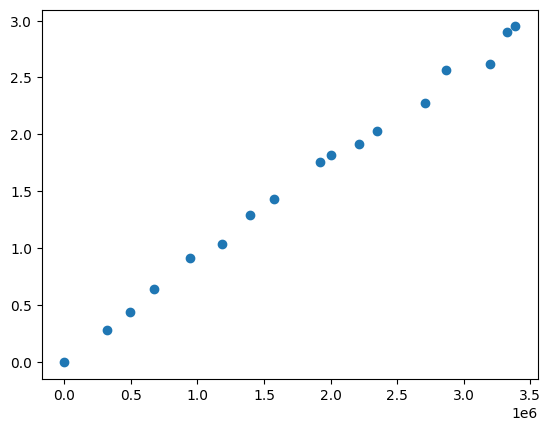

In [42]:
import matplotlib.pyplot as plt

def plot():
    x = [0, 322000, 493000, 673000, 943000, 1183000, 1393000, 1573000, 1921000, 2000000, 2210000, 2346000,
         2706000, 2870000, 3200000, 3328000, 3386000]
    y = [a / 1024 for a in [0, 292, 451, 660, 941, 1060, 1320, 1470, 1800, 1860, 1960, 2080, 2330, 2630, 2680, 2970, 3020]]

    plt.scatter(x, y)
    plt.show()

plot()

7. Porównanie wsparcia da popularnych jezyków programowania oraz próba określenia łatwości korzystania z dokumentacji i jej kompletności

Java jest jedynym językiem programowania, który jest bezpośrednio wspierany przez Solr. Niestety, mimo to dokumentacja bywa przestarzała - klasa `HttpSolrClient` jest już oznaczona jako deprecated, jednakże stanowi trzon przykładów użycia klienta.

Aby korzystać z innego języka programowania niż Java, można wykorzystać zapytania HTTP. Niestety, informacje o korzystaniu z nich są bardzo wybrakowane. Przykładowo, problemem było już samo zadeklarowanie struktury indeksowanych dokumentów, gdyż dokumentacja nigdzie nie specyfikuje dostępnych typów danych. Jedynym miejscem, w którym można je znaleźć, jest przykład użycia:

![solr](./images/solr1.png)